## Install & Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE

##  Load & Inspect the Dataset

In [2]:
# Load the dataset
file_path = "/workspace/Diploma_Project/updated_clinical_data.csv"  # Update if needed
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,case_id,CPTAC_TCGA_Tissues_data_file_name,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,...,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split,chosen_exam
0,C3L-00004,C3L-00004-26.svs,1,6.0,3,NaN,7,0,1,0,...,0,0,0,1,0,1,1,0,train,C3L-00004-26.npz
1,C3L-00010,C3L-00010-26.svs,1,1.0,3,NaN,3,1,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00010-26.npz
2,C3L-00011,C3L-00011-26.svs,0,5.0,4,1.0,8,0,2,2,...,0,0,0,1,0,1,0,1,train,C3L-00011-26.npz
3,C3L-00026,C3L-00026-21.svs,0,5.0,3,NaN,2,0,1,0,...,0,0,0,1,0,1,0,1,train,C3L-00026-21.npz
4,C3L-00079,C3L-00079-26.svs,1,3.0,3,NaN,8,2,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00079-26.npz


In [3]:
# List of columns to drop
columns_to_drop = ['CPTAC_TCGA_Tissues_data_file_name', 'chosen_exam']  # Replace with your column names

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Display the first few rows after dropping columns
print("\nAfter dropping columns:")
df.head()


After dropping columns:


,case_id,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,vital_status_12,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split
0,C3L-00004,1,6.0,3,NaN,7,0,1,0,3,1,0,0,0,1,0,1,1,0,train
1,C3L-00010,1,1.0,3,NaN,3,1,1,0,1,1,0,0,0,1,0,1,0,0,train
2,C3L-00011,0,5.0,4,1.0,8,0,2,2,3,0,0,0,0,1,0,1,0,1,train
3,C3L-00026,0,5.0,3,NaN,2,0,1,0,1,1,0,0,0,1,0,1,0,1,train
4,C3L-00079,1,3.0,3,NaN,8,2,1,0,3,0,0,0,0,1,0,1,0,0,train


## Check Dataset Information & Missing Values

In [4]:
# Get basic info about dataset
df.info()

# Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   case_id                         618 non-null    object 
 1   gender                          618 non-null    int64  
 2   age_diag                        601 non-null    float64
 3   grade                           618 non-null    int64  
 4   cancer_history                  73 non-null     float64
 5   ajcc_path_tumor_pt              618 non-null    int64  
 6   ajcc_path_nodes_pn              618 non-null    int64  
 7   ajcc_clin_metastasis_cm         618 non-null    int64  
 8   ajcc_path_metastasis_pm         618 non-null    int64  
 9   ajcc_path_tumor_stage           618 non-null    int64  
 10  vital_status_12                 618 non-null    int64  
 11  race_Asian                      618 non-null    int64  
 12  race_Black or African American  618 

Handle Missing Data

In [5]:
from sklearn.impute import SimpleImputer

# Handle missing categorical values
imputer = SimpleImputer(strategy="most_frequent")
df["cancer_history"] = imputer.fit_transform(df[["cancer_history"]])

# Handle missing numerical values
df["age_diag"] = df["age_diag"].fillna(df["age_diag"].median())
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].replace(-1, np.nan)
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].fillna(df["ajcc_path_tumor_stage"].mode()[0])

Feature Encoding

In [6]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_cols = ["ajcc_path_tumor_stage", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm"]
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

df = pd.get_dummies(df, columns=["gender"], drop_first=True)

Feature Scaling

In [7]:
# Scale Numerical Features using MinMaxScaler
numerical_cols = ["age_diag", "grade", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                  "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm", "ajcc_path_tumor_stage"]

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Feature Selection

In [8]:
# Final Feature Selection
target_col = "vital_status_12"
feature_cols = [col for col in df.columns if col not in ["case_id", "vital_status_12", "Split"]]
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.int64)

Handle Class Imbalance Using ADASYN (Alternative to SMOTE)

In [9]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

## Train-Test Split

In [10]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (871, 17), Test Set: (218, 17)


Visualize Class Distribution Before and After ADASYN

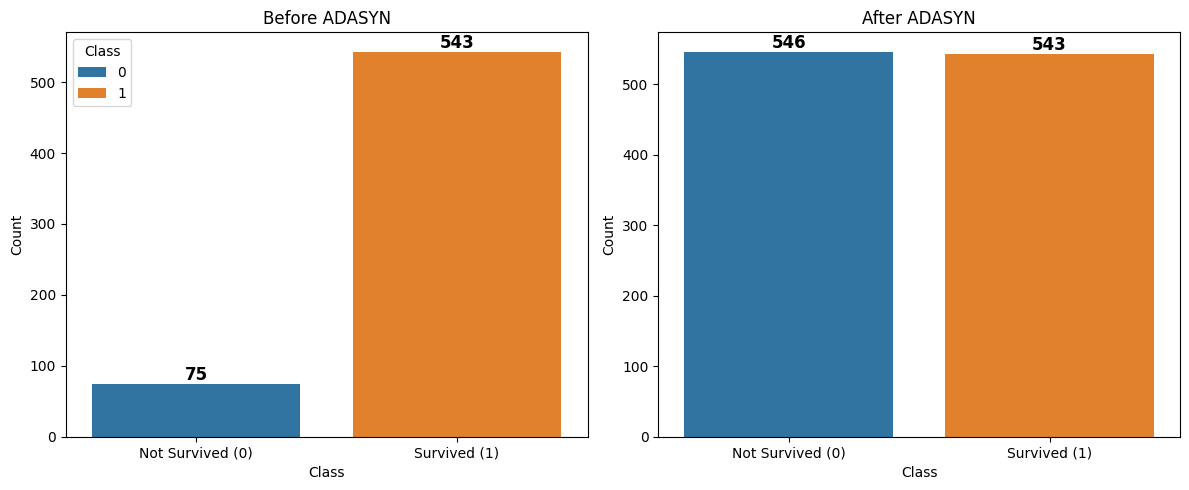

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Before
original_counts = Counter(y)
df_original = pd.DataFrame.from_dict(original_counts, orient='index', columns=['Count']).reset_index()
df_original.columns = ['Class', 'Count']

# After
resampled_counts = Counter(y_resampled)
df_resampled = pd.DataFrame.from_dict(resampled_counts, orient='index', columns=['Count']).reset_index()
df_resampled.columns = ['Class', 'Count']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before ADASYN
sns.barplot(data=df_original, x="Class", y="Count", ax=ax[0], hue="Class", dodge=False)
ax[0].set_title("Before ADASYN")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for container in ax[0].containers:
    for bar in container:
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width() / 2., height + 5, f'{int(height)}',
                   ha='center', fontsize=12, fontweight='bold')

# After ADASYN
sns.barplot(data=df_resampled, x="Class", y="Count", ax=ax[1], hue="Class", dodge=False)
ax[1].set_title("After ADASYN")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for container in ax[1].containers:
    for bar in container:
        height = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width() / 2., height + 5, f'{int(height)}',
                   ha='center', fontsize=12, fontweight='bold')

plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig("adasyn_class_distribution.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


Assign Patient IDs Back to ADASYN Samples

In [ ]:
import numpy as np

original_case_ids = df["case_id"].values
X_original = df[feature_cols].values.astype(np.float32)
y_original = df["vital_status_12"].values.astype(np.int64)

# Number of new samples generated
num_original = len(y_original)
num_synthetic = len(y_resampled) - num_original

# Get synthetic indices and use ADASYN's sampling strategy to track nearest neighbors
synthetic_indices = np.arange(num_original, len(y_resampled))
neighbors = adasyn.nn_.kneighbors(X_resampled[synthetic_indices], return_distance=False)[:, 0]
synthetic_case_ids = original_case_ids[neighbors]

# Final ID assignment
case_ids_balanced = np.concatenate([original_case_ids, synthetic_case_ids])

# Save full dataset
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced["vital_status_12"] = y_resampled
df_balanced["case_id"] = case_ids_balanced

df_balanced.to_csv("/content/balanced_clinical_data_ADASYN.csv", index=False)
print("✅ Balanced dataset saved using ADASYN.")

✅ Balanced dataset saved using ADASYN.


Link Balanced Data with Slide IDs and Save Final CSV for CLAM

In [ ]:
import pandas as pd

# Load datasets
balanced_data = pd.read_csv("/content/balanced_clinical_data_ADASYN.csv")  # New ADASYN-balanced data
slide_data = pd.read_csv("/content/dataset_with_labels.csv")               # Contains case_id to slide_id mapping

# Build mapping from case_id to slide_id
slide_mapping = slide_data.set_index("case_id")["slide_id"].to_dict()

# Assign slide_id to each case_id
balanced_data["slide_id"] = balanced_data["case_id"].map(slide_mapping)

# Rename target column to "label" (required by CLAM)
balanced_data.rename(columns={"vital_status_12": "label"}, inplace=True)

# Fill in placeholder slide_ids for synthetic rows not found in the original mapping
for index, row in balanced_data.iterrows():
    if pd.isna(row["slide_id"]):
        balanced_data.at[index, "slide_id"] = f"{row['case_id']}-XX"  # Marked as synthetic or unmatched

# Create final dataset with required columns
final_data = balanced_data[["case_id", "slide_id", "label"]]

# Save final dataset for CLAM
final_data.to_csv("/content/final_clam_ready.csv", index=False)

# Show a preview
print("✅ Final dataset ready for CLAM:")
print(final_data.head())


✅ Final dataset ready for CLAM:
     case_id      slide_id  label
0  C3L-00004  C3L-00004-26      1
1  C3L-00010  C3L-00010-26      1
2  C3L-00011  C3L-00011-26      0
3  C3L-00026  C3L-00026-21      1
4  C3L-00079  C3L-00079-26      0


### visually compare the two datasets:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
adasyn_df = pd.read_csv("/content/final_clam_ready.csv")
smote_df = pd.read_csv("/content/dataset_with_labels_using_SMOTE.csv")


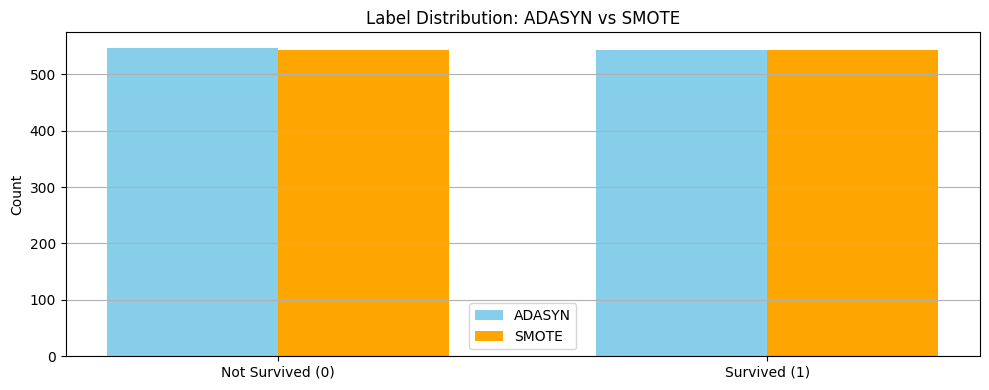

In [ ]:
# Count labels
label_counts_adasyn = adasyn_df["label"].value_counts().sort_index()
label_counts_smote = smote_df["label"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
bar_width = 0.35
index = [0, 1]

plt.bar(index, label_counts_adasyn, bar_width, label='ADASYN', color='skyblue')
plt.bar([i + bar_width for i in index], label_counts_smote, bar_width, label='SMOTE', color='orange')

plt.xticks([i + bar_width/2 for i in index], ['Not Survived (0)', 'Survived (1)'])
plt.ylabel("Count")
plt.title("Label Distribution: ADASYN vs SMOTE")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


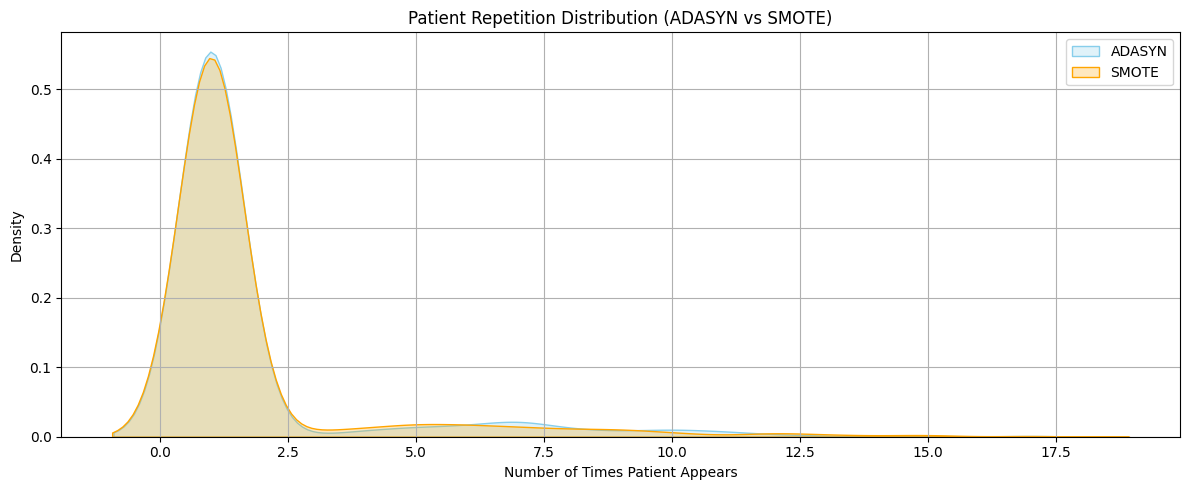

In [ ]:
# Count patient appearances
adasyn_counts = adasyn_df["case_id"].value_counts()
smote_counts = smote_df["case_id"].value_counts()

# Distribution of repetitions
plt.figure(figsize=(12, 5))
sns.kdeplot(adasyn_counts, label="ADASYN", fill=True, color="skyblue")
sns.kdeplot(smote_counts, label="SMOTE", fill=True, color="orange")

plt.xlabel("Number of Times Patient Appears")
plt.ylabel("Density")
plt.title("Patient Repetition Distribution (ADASYN vs SMOTE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-35-ad68cc78a101>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_adasyn.values, y=top_adasyn.index, ax=ax[0], palette="Blues_r")
<ipython-input-35-ad68cc78a101>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_smote.values, y=top_smote.index, ax=ax[1], palette="Oranges_r")


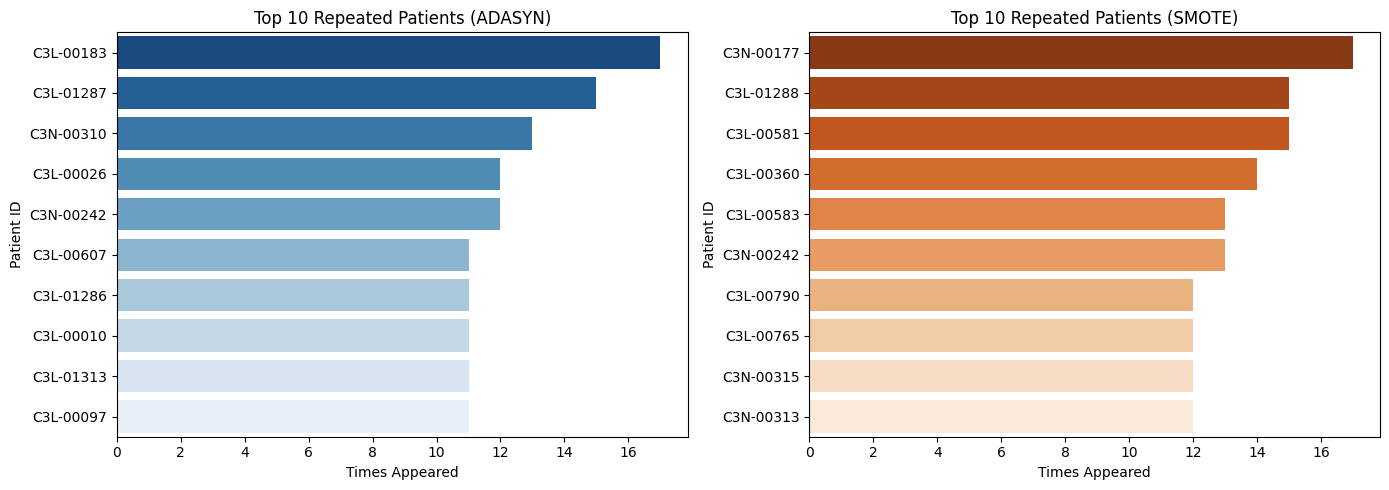

In [ ]:
# Top repeated patients
top_adasyn = adasyn_counts.head(10)
top_smote = smote_counts.head(10)

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=top_adasyn.values, y=top_adasyn.index, ax=ax[0], palette="Blues_r")
ax[0].set_title("Top 10 Repeated Patients (ADASYN)")
ax[0].set_xlabel("Times Appeared")
ax[0].set_ylabel("Patient ID")

sns.barplot(x=top_smote.values, y=top_smote.index, ax=ax[1], palette="Oranges_r")
ax[1].set_title("Top 10 Repeated Patients (SMOTE)")
ax[1].set_xlabel("Times Appeared")
ax[1].set_ylabel("Patient ID")

plt.tight_layout()
plt.show()


## Define an Improved PyTorch Dataset & Model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Create PyTorch Dataset
class ClinicalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataloaders
batch_size = 32
train_dataset = ClinicalDataset(X_train, y_train)
test_dataset = ClinicalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Improved MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, 2)  # Binary classification (Survival/No Survival)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_size=X.shape[1]).to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 6.0]).to(device))  # Weighted loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

##  Train the Model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop with better logging
num_epochs = 50
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    correct, total, running_loss = 0, 0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Reduce learning rate if loss does not improve
    scheduler.step(epoch_loss)

    # Print loss & accuracy every 5 epochs instead of every epoch
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")




/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/50 - Loss: 0.2966, Accuracy: 0.5787
Epoch 10/50 - Loss: 0.2631, Accuracy: 0.6988
Epoch 15/50 - Loss: 0.2352, Accuracy: 0.7316
Epoch 20/50 - Loss: 0.2357, Accuracy: 0.7644
Epoch 25/50 - Loss: 0.2033, Accuracy: 0.7690
Epoch 30/50 - Loss: 0.1997, Accuracy: 0.7690
Epoch 35/50 - Loss: 0.1908, Accuracy: 0.8256
Epoch 40/50 - Loss: 0.1701, Accuracy: 0.8414
Epoch 45/50 - Loss: 0.1685, Accuracy: 0.8437
Epoch 50/50 - Loss: 0.1606, Accuracy: 0.8460


## Plot Training Performance (Accuracy & Loss Curves)

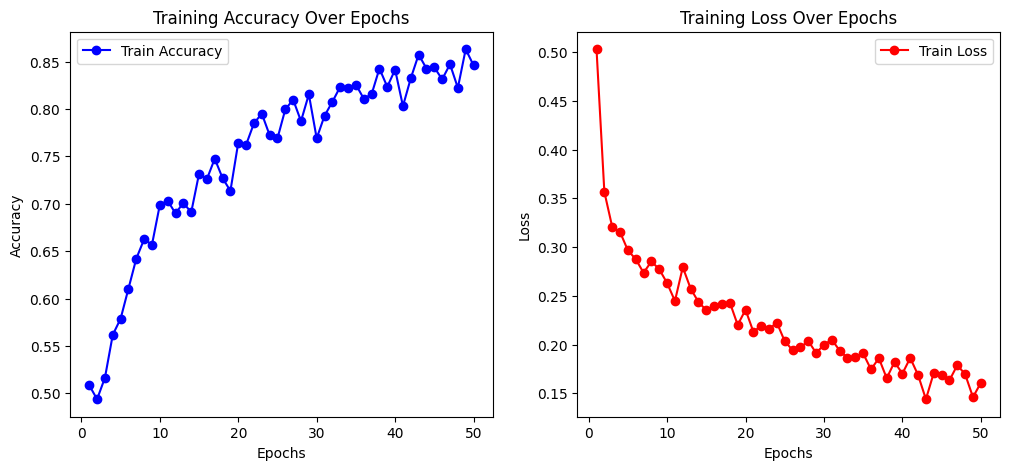

In [14]:
# Plot Train Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.show()


##  Evaluate Model on Test Data

In [15]:
# Evaluate on test set
model.eval()  # Set model to evaluation mode
correct, total, running_loss = 0, 0, 0.0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)[:, 1]  # Get probability for positive class

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Compute final test accuracy and loss
test_loss = running_loss / len(test_loader)
test_accuracy = correct / total

print(f"\n🔹 Test Loss: {test_loss:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\n🔹 Classification Report:\n", classification_report(all_labels, all_preds))



🔹 Test Loss: 0.1060
🔹 Test Accuracy: 0.9095

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       112
           1       0.85      0.99      0.92       109

    accuracy                           0.91       221
   macro avg       0.92      0.91      0.91       221
weighted avg       0.92      0.91      0.91       221



## Plot Evaluation Metrics (Confusion Matrix & ROC Curve)

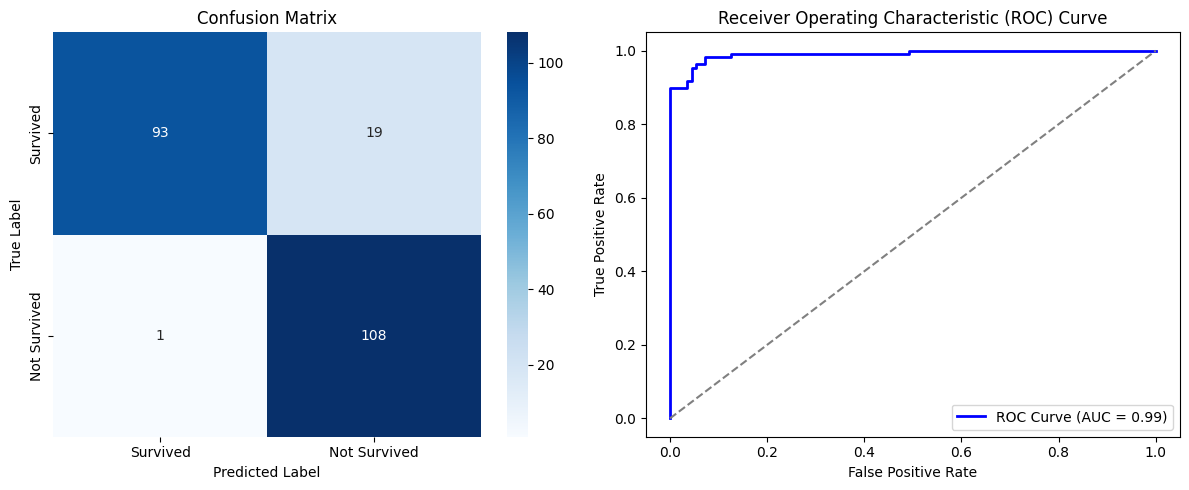

In [16]:
plt.figure(figsize=(12, 5))

# Confusion Matrix on the left
plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Survived", "Not Survived"], yticklabels=["Survived", "Not Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# ROC Curve on the right
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
